TODO: do supervised learning to predict "success", where success is measured by further interaction by user.  Could
set a threshold and ocnvert to "sucess" or "fail" and then build a nn to predict whether a query will be successful or not.
If not, then could provide recs that correspond to nearest successful cluster

# Clustering user queries using Fashion CLIP embeddings v2

### Introduction

Start with csv of queries and filters: /Users/mingham/research/workspaces/search_and_recs/cache/series_queries.csv

see clustering_queries.ipynb for how these were loaded

In [36]:
# !pip install --no-binary snowflake-connector-python --force-reinstall "https://github.com/iserko/snowflake-connector-python/archive/refs/heads/SNOW-XXXXXX_wait_for_url_input_after_sso.zip#egg=snowflake-connector-python[secure-local-storage]" -q
# !pip install --user annoy
# !pip install transformers
import os
import pandas as pd
import snowflake.connector
import traceback
import matplotlib.pyplot as plt
import pickle
import numpy as np
import ast
import torch
import requests
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import sklearn as sk
from pathlib import Path
from io import BytesIO
from transformers import AutoProcessor, AutoModel, AutoTokenizer, CLIPTextModelWithProjection 
from typing import Callable, Dict, Iterator
# from PIL import Image
# from annoy import AnnoyIndex
# from torchvision import transforms
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from importlib import reload

import pydqt
# set workspace
pydqt.set_workspace('/Users/mingham/research/workspaces/','search_and_recs')

# import local embeddings code
import sys
sys.path.append('../src/')
import embeddings
import clustering as clustering

queries_csv = '/Users/mingham/research/workspaces/search_and_recs/cache/series_queries.csv'


### Calculate embeddings of queries using the Fashion CLIP model
v2 uses src/clustering.py module

In [4]:
embeddings_path = '/Users/mingham/research/src'
embedding_idx = 0
embeddings_df = pd.read_csv(f'{embeddings_path}/embeddings_{embedding_idx}.csv')
# embeddings2_df, column_names = clustering.create_ortho_embeddings(embeddings_df)

In [5]:
embeddings_df

,query,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512
0,arcteryx,-0.395560,-0.262860,-0.284100,0.011488,0.076927,0.110884,-0.285859,-0.326531,0.206412,...,-0.090949,-0.385271,0.618263,0.254585,-0.120005,0.444667,-0.412261,0.316306,0.152145,0.313028
1,maxi dresses,0.143916,0.229968,-0.115475,-0.314809,-0.458020,-0.212207,0.135059,-0.199067,-0.210132,...,-0.515929,0.213758,-0.092813,0.306110,-0.547499,0.096689,0.120332,-0.086583,-0.293282,-0.027134
2,ombre,-0.042962,-0.105800,-0.312130,-0.075232,0.104917,-0.682406,0.211086,0.011595,-0.509873,...,0.490269,0.496583,0.007607,0.167649,0.256382,-0.256495,-0.144386,0.114731,-0.054913,-0.113850
3,leather men watches,-0.199659,-0.196586,-0.317964,-0.056889,-0.154712,0.193010,-0.540888,0.230961,0.236104,...,0.241771,0.019140,0.169263,0.186371,-0.234857,-0.209304,-0.567151,0.335694,0.112867,0.039943
4,veja sneakers,-0.665682,0.027221,0.017952,0.090470,0.412678,0.116795,0.288420,0.510706,-0.261173,...,0.203052,-0.389767,-0.063641,0.221538,0.120219,0.321691,0.118836,0.817288,0.120002,0.386504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,gucci sunglasses man men sunglasses,-0.069499,-0.178276,-0.364105,0.426969,0.267143,-0.290689,-0.000035,-0.055167,0.051008,...,0.329012,-0.282919,-0.073627,0.155520,0.242745,0.507153,-0.033691,0.327406,0.048072,0.426959
9796,adidas campus women sneakers shoes,-0.223716,-0.167532,0.225512,0.047612,0.103533,-0.321556,-0.246503,0.331763,-0.064343,...,0.317382,-0.126430,-0.010789,0.008653,0.397690,0.265546,-0.342552,0.471020,-0.201314,0.219704
9797,adidas campus women,-0.040021,-0.172015,0.192343,-0.018888,-0.031713,-0.303292,-0.269734,0.195173,-0.140023,...,0.287538,-0.090998,0.056182,0.011296,0.328406,0.265950,-0.304207,0.550052,-0.264351,0.275440
9798,sweater men,-0.189443,-0.129660,-0.571684,0.249088,0.131924,-0.470789,-0.082491,-0.331884,-0.233539,...,0.260300,-0.187784,0.202512,0.241303,0.326814,0.273237,0.072943,0.162269,-0.007796,-0.215523


Let's create a pipeline to handle standardisation and add dimensionality reduction.  Silhouette scores naturally decline in higher dimensional space

In [88]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA


class Settings:
    n_components = 10
    n_clusters = 20
    random_state = 42
    def __repr__(self):
        return f"""
    settings:
        n_components:   {self.n_components}
        n_clusters:     {self.n_clusters}
        random_state:   {self.random_state}
    """    
settings = Settings()


columns = [x for x in embeddings_df.columns if x!='query']
data = embeddings_df[columns].to_numpy()



In [94]:
process_pipe = make_pipeline(
    Normalizer(),
    # PCA(n_components=settings.n_components, random_state=settings.random_state)
    PCA(random_state=settings.random_state)    
)
pipe = Pipeline([
    ('process',process_pipe),
    ('kmeans', KMeans(
               n_clusters=settings.n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=settings.random_state,
        )
     )
])




pipe.fit(data)
# pipe["process"]["normalizer"].transform(data)
# pipe["kmeans"].labels_
# x=pipe["process"].transform(data)

Pipeline(steps=[('process',
                 Pipeline(steps=[('normalizer', Normalizer()),
                                 ('pca', PCA(random_state=42))])),
                ('kmeans',
                 KMeans(max_iter=500, n_clusters=20, n_init=50,
                        random_state=42))])

## Hierarchical clustering of embeddings

### Step 1: Agglomerative kmeans clustering

Do the KMeans (using sklearn with unit embeddings, i.e. embeddings_df2)

In [ ]:
clusterer = clustering.compute_hierachical_clusters(embeddings2_df, column_names, True)

In [ ]:
reload(clustering)

<module 'clustering' from '/Users/mingham/research/notebooks/../src/clustering.py'>

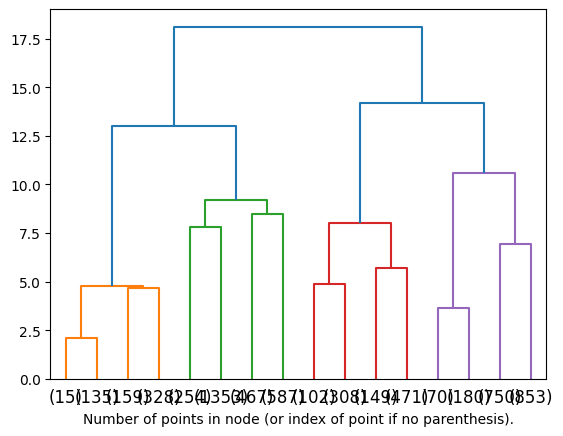

In [ ]:
clustering.plot_dendrogram(clusterer,truncate_mode="level", p=3)

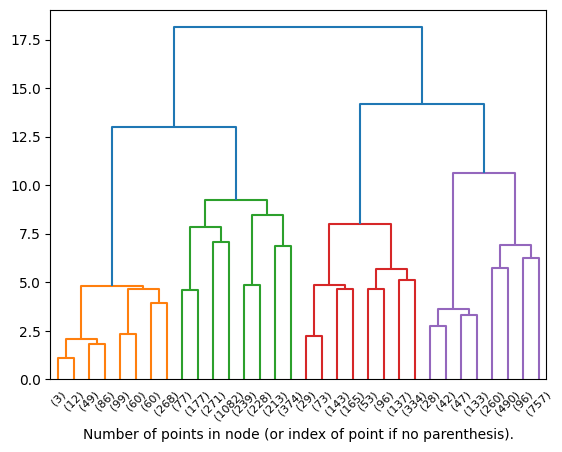

In [ ]:
clustering.plot_dendrogram(clusterer,truncate_mode="level", p=4)